# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC 
%matplotlib inline

## Explore Data set

In [2]:
car_path = np.concatenate([glob.glob(path + '/*.png') for path in glob.glob('./vehicles/*')])
notcar_path = np.concatenate([glob.glob(path + '/*.png') for path in glob.glob('./non-vehicles/*')])

Number of cars and notcar datas

In [3]:
n_car = car_path.shape[0]
n_notcar = notcar_path.shape[0]
t_img = cv2.imread(car_path[0])
print('Num of car datas:',n_car)
print('Num of notcar datas:', n_notcar)
print('Data shape:', t_img.shape)

Num of car datas: 8792
Num of notcar datas: 8968
Data shape: (64, 64, 3)


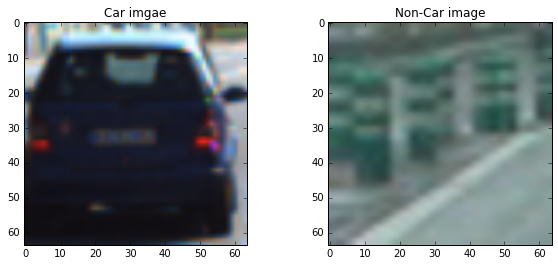

In [4]:
random_car_ind = np.random.randint(0, len(car_path))
random_notcar_ind = np.random.randint(0, len(notcar_path))

car_img_BGR = cv2.imread(car_path[random_car_ind])
car_img = cv2.cvtColor(car_img_BGR, cv2.COLOR_BGR2RGB)

notcar_img_BGR = cv2.imread(notcar_path[random_notcar_ind])
notcar_img = cv2.cvtColor(notcar_img_BGR, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car imgae')
plt.subplot(122)
plt.imshow(notcar_img)
plt.title("Non-Car image")
plt.savefig('./output_images/Car_notCar_img.png')

## Spatial bins

The first feature can get form image consists of raw color value, Color features The color feature can be distinguished from the surrounding color environment, but this is only an auxiliary tool for vehicle detection.

In [5]:
def bin_spatial(img, bin_size=32, vis=False):
    if vis == True:
        return cv2.resize(img, (bin_size, bin_size))
    else:
        color1 = cv2.resize(img[:,:,0], (bin_size, bin_size)).ravel()
        color2 = cv2.resize(img[:,:,1], (bin_size, bin_size)).ravel()
        color3 = cv2.resize(img[:,:,2], (bin_size, bin_size)).ravel()
        return np.hstack((color1, color2, color3))

In [6]:
resize_img = bin_spatial(car_img, vis=True)
feature_vector = bin_spatial(car_img)

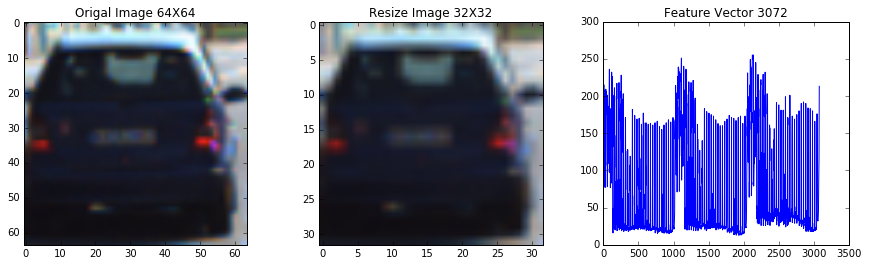

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
ax[0].imshow(car_img)
ax[0].set_title('Origal Image 64X64')
ax[1].imshow(resize_img)
ax[1].set_title('Resize Image 32X32')
ax[2].plot(feature_vector)
ax[2].set_title('Feature Vector 3072')
#ax[2].limx(feature_vector.shape[0], xlim=(0, feature_vector.shape[0]))
plt.savefig('./output_images/spatial_bins.png')

## Color Histogram

In [8]:
# Define a function to compute color histogram features  
def color_hist(image, nbin=32, bin_range=(0, 256), output_chs=False):
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(image[:,:,0], bins=nbin, range=bin_range)
    ch2_hist = np.histogram(image[:,:,1], bins=nbin, range=bin_range)
    ch3_hist = np.histogram(image[:,:,2], bins=nbin, range=bin_range)
    if output_chs == True:
        bin_edges = ch1_hist[1]
        bin_centers = (bin_edges[1:] + bin_edges[:len(bin_edges)-1])/2
        return ch1_hist[0], ch2_hist[0], ch2_hist[0], bin_centers
    else:
        return np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

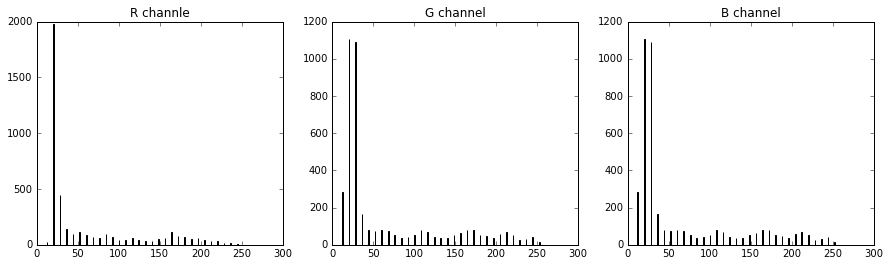

In [9]:
r_hist, g_hist, b_hist, centers = color_hist(car_img, output_chs=True)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
ax[0].bar(centers, r_hist)
ax[0].set_title('R channle')
ax[1].bar(centers, g_hist)
ax[1].set_title('G channel')
ax[2].bar(centers, b_hist)
ax[2].set_title('B channel')
plt.savefig('./output_images/Color_hist.png')
#ax[2].limx(feature_vector.shape[0], xlim=(0, feature_vector.shape[0]))

## HOG features

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [11]:
test_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
_, hog_image = get_hog_features(test_gray, 9, 8, 2,True)

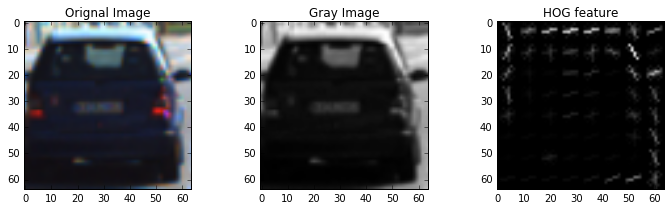

In [12]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(car_img)
plt.title('Orignal Image')
plt.subplot(132)
plt.imshow(test_gray, cmap='gray')
plt.title('Gray Image')
plt.subplot(133)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG feature')
plt.savefig('./output_images/hog_feature.png')

## Turning Parameters

In [14]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=32,
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image_BGR = cv2.imread(file)
        image = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
        
        feature_image = convert_color(image, color_space=color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, bin_size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [15]:
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = img
    return feature_image

In [17]:
import time
from sklearn.utils import shuffle

In [18]:
shuf_car_path = shuffle(car_path)
shuf_notcar_path = shuffle(notcar_path)

### random select 1300 data set

In [19]:
test_car_path = shuf_car_path[:1321]
test_notcar_path = shuf_notcar_path[:1305]

In [20]:
def turn_parmeters(car_path, notcar_path, color_space, 
                   hog_channel, spatial_feat, hist_feat,
                   hog_feat, orient, pix_per_cell,
                   cell_per_block, hist_bins, spatial_size):
    
    test_car_features = extract_features(test_car_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    test_notcar_features = extract_features(test_notcar_path, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Create an array stack of feature vectors
    X = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    #svc = SVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    acc = round(svc.score(X_test, y_test), 4)
    #print('Test Accuracy of SVC = ', acc)
    # Check the prediction time for a single sample
    test_time = round(t2-t, 2)
    len_vector = len(X_train[0])
    return acc, test_time, len_vector

In [21]:
# setting test parmeters
orient = 8
pix_per_cell = 8
cell_per_block = 2
hist_bins = 16
spatial_size = 16

# Turning parameters, to find which could be better
color_pars = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

hog_channel_pars = [0,1,2,'ALL']
spatial_feat_pars = [True, False] # Spatial features on or off
hist_feat_pars = [True, False] # Histogram features on or off
hog_feat_pars = [True, False] # HOG features on or off
states = []

Different color space has great influence on the training machine, In order to get better results, I will adjust the parameters to facilitate future SVM to use.
Turing which color space could be better. This code will be run maybe 10 minutes.

### This program may have to run for more than 18 minutes. No need to run here, just provide a choice for `color_space`, `spatial_feat`,`hist_feat`,`hog_feat`.

In [22]:
print('Processing...')
for turn_color in color_pars: 
    print('Color Space : '+turn_color)
    t = time.time()
    for turn_hog_ch in hog_channel_pars:
        t11 = time.time()
        print('HOG CH :' + str(turn_hog_ch))
        for turn_spatial in spatial_feat_pars:
            for turn_hist in hist_feat_pars:
                for turn_hog in hog_feat_pars:
                    if turn_spatial == turn_hist == turn_hog == False:
                        pass
                    else:
                        str_hog = str(turn_hog)
                        
                        accuracy, test_time, len_vector = turn_parmeters(test_car_path, 
                                                                         test_notcar_path,
                                                                         color_space=turn_color,
                                                                         hog_channel=turn_hog_ch,
                                                                         spatial_feat=turn_spatial,
                                                                         hist_feat=turn_hist,
                                                                         hog_feat=turn_hog,
                                                                         orient=orient,
                                                                         pix_per_cell=pix_per_cell,
                                                                         cell_per_block=cell_per_block,
                                                                         hist_bins=hist_bins,
                                                                         spatial_size=spatial_size)
                        
                        states.append((turn_color, turn_hog_ch, turn_spatial, turn_hist,\
                                       turn_hog, len_vector, accuracy, str(test_time)))
        t12 = time.time()
        print('HOG CH ' + str(turn_color) +' time :', round((t12-t11), 2))
        print()
    t2 = time.time()
    print('Test '+ turn_color +' :', round((t2-t),2))
    print()
print('Finished!')

Processing...
Color Space : RGB
HOG CH :0
HOG CH RGB time : 40.3

HOG CH :1
HOG CH RGB time : 37.74

HOG CH :2
HOG CH RGB time : 37.64

HOG CH :ALL
HOG CH RGB time : 77.97

Test RGB : 193.66

Color Space : HSV
HOG CH :0
HOG CH HSV time : 30.02

HOG CH :1
HOG CH HSV time : 31.58

HOG CH :2
HOG CH HSV time : 30.3

HOG CH :ALL
HOG CH HSV time : 78.24

Test HSV : 170.14

Color Space : LUV
HOG CH :0
HOG CH LUV time : 35.02

HOG CH :1
HOG CH LUV time : 30.3

HOG CH :2
HOG CH LUV time : 37.15

HOG CH :ALL
HOG CH LUV time : 66.06

Test LUV : 168.52

Color Space : HLS
HOG CH :0
HOG CH HLS time : 37.12

HOG CH :1
HOG CH HLS time : 33.38

HOG CH :2
HOG CH HLS time : 33.27

HOG CH :ALL
HOG CH HLS time : 76.55

Test HLS : 180.32

Color Space : YUV
HOG CH :0
HOG CH YUV time : 31.62

HOG CH :1
HOG CH YUV time : 27.66

HOG CH :2
HOG CH YUV time : 36.27

HOG CH :ALL
HOG CH YUV time : 68.16

Test YUV : 163.71

Color Space : YCrCb
HOG CH :0
HOG CH YCrCb time : 31.75

HOG CH :1
HOG CH YCrCb time : 29.42



The results of the program run will be different each time, I chose YCrCb, vector features the length of moderate.

In [23]:
import pandas as pd
df = pd.DataFrame(states, columns=['Color','Channel','Spatial','Hist','HOG','len_vector','Accuracy','Time'])
df.sort_values(by=['Accuracy'],ascending=False)[:10]

Color Channel  Spatial   Hist   HOG  len_vector  Accuracy  Time
77     LUV     ALL     True   True  True        5520    0.9886  0.51
133    YUV     ALL     True   True  True        5520    0.9791  0.54
63     LUV       1     True   True  True        2384    0.9772  0.24
79     LUV     ALL     True  False  True        5472    0.9772   0.5
161  YCrCb     ALL     True   True  True        5520    0.9753  0.45
65     LUV       1     True  False  True        2336    0.9715  0.28
105    HLS     ALL     True   True  True        5520    0.9715  0.67
49     HSV     ALL     True   True  True        5520    0.9696  5.36
51     HSV     ALL     True  False  True        5472    0.9696  5.77
165  YCrCb     ALL    False   True  True        4752    0.9677  0.63

In [72]:
# Debug Paramters
pars_orient = [2,4,8,9,10]
pars_pix_per_cell = [4,8,16,32]
pars_cell_per_block = [1,2,4,8]

pix_per_cell = 8
cell_per_block = 2
hist_bins = 16
spatial_size = 16
color_space = 'YCrCb'
hog_channel = 'ALL'
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [73]:
shuf_car_path = shuffle(car_path)
shuf_notcar_path = shuffle(notcar_path)
test_car_path = shuf_car_path[:1300]
test_notcar_path = shuf_notcar_path[:1300]

In [74]:
orient_states = []
print('Processing...')
for turn_orient in pars_orient:
    t1 = time.time()
    print('Value of orient :', turn_orient)
    accuracy, test_time, len_vector = turn_parmeters(car_path=test_car_path,
                                                     notcar_path=test_notcar_path,
                                                     orient= turn_orient,
                                                     pix_per_cell=pix_per_cell,
                                                     cell_per_block=cell_per_block,
                                                     hist_bins=hist_bins,
                                                     spatial_size=spatial_size,
                                                     color_space=color_space,
                                                     hog_channel=hog_channel,
                                                     spatial_feat=spatial_feat,
                                                     hist_feat=hist_feat,
                                                     hog_feat=hog_feat)
    orient_states.append((turn_orient, len_vector, accuracy, test_time))
    t2 = time.time()
    print('Time: ', round((t2-t1), 2))
print('Finished!')
print()

Processing...
Value of orient : 2
Time:  13.99
Value of orient : 4
Time:  11.92
Value of orient : 8
Time:  14.01
Value of orient : 9
Time:  14.39
Value of orient : 10
Time:  14.34
Finished!



In [75]:
df_orients = pd.DataFrame(orient_states, columns=['val_orient','len_vector','accuracy','Time'])
df_orients.sort_values(by=['accuracy'],ascending=False)

val_orient  len_vector  accuracy  Time
2           8        5520    0.9865  0.41
0           2        1992    0.9769  0.95
4          10        6696    0.9750  0.47
3           9        6108    0.9731  0.44
1           4        3168    0.9654  0.31

In [81]:
shuf_car_path = shuffle(car_path)
shuf_notcar_path = shuffle(notcar_path)
test_car_path = shuf_car_path[:1300]
test_notcar_path = shuf_notcar_path[:1300]

In [82]:
final_orient = 8

pix_per_cell_states = []
print('Processing...')
for turn_pix_per_cell in pars_pix_per_cell:
    t1 = time.time()
    print('Value of pix_per_cell :', turn_pix_per_cell)
    accuracy, test_time, len_vector = turn_parmeters(car_path=test_car_path,
                                                     notcar_path=test_notcar_path,
                                                     orient= final_orient, ## Final orient
                                                     pix_per_cell=turn_pix_per_cell, # turn parameter
                                                     cell_per_block=cell_per_block,
                                                     hist_bins=hist_bins,
                                                     spatial_size=spatial_size,
                                                     color_space=color_space,
                                                     hog_channel=hog_channel,
                                                     spatial_feat=spatial_feat,
                                                     hist_feat=hist_feat,
                                                     hog_feat=hog_feat)
    pix_per_cell_states.append((turn_pix_per_cell, len_vector, accuracy, test_time))
    t2 = time.time()
    print('Time: ', round((t2-t1), 2))
    print()
print('Finished!')

Processing...
Value of pix_per_cell : 4
Time:  45.76

Value of pix_per_cell : 8
Time:  13.78

Value of pix_per_cell : 16
Time:  7.03

Value of pix_per_cell : 32
Time:  5.29

Finished!


As mentioned above, pix_per_cell is also faced with the same problem. The accuracy of different values is also unstable, and pix_per_Cell=8 may be the best choice.

In [84]:
df_pix_per_cell = pd.DataFrame(pix_per_cell_states, columns=['val_pix_per_cell','len_vector','accuracy','Time'])
df_pix_per_cell.sort_values(by=['accuracy'],ascending=False)

val_pix_per_cell  len_vector  accuracy  Time
1                 8        5520    0.9808  0.45
0                 4       22416    0.9750  1.68
2                16        1680    0.9750  0.22
3                32         912    0.9673  0.28

### Turning cell_per_block

In [90]:
shuf_car_path = shuffle(car_path)
shuf_notcar_path = shuffle(notcar_path)
test_car_path = shuf_car_path[:1300]
test_notcar_path = shuf_notcar_path[:1300]

In [91]:
final_pix_per_cell = 8
pars_cell_per_block = [1,2,4,8]

cell_per_block_states = []
print('Processing...')
for turn_cell_per_block in pars_cell_per_block:
    t1 = time.time()
    print('Value of cell_per_block :', turn_cell_per_block)
    accuracy, test_time, len_vector = turn_parmeters(car_path=test_car_path,
                                                     notcar_path=test_notcar_path,
                                                     orient= final_orient, ## Final orient
                                                     pix_per_cell=final_pix_per_cell, ## Final pix_per_cell
                                                     cell_per_block=turn_cell_per_block, # turn cell_per_block
                                                     hist_bins=hist_bins,
                                                     spatial_size=spatial_size,
                                                     color_space=color_space,
                                                     hog_channel=hog_channel,
                                                     spatial_feat=spatial_feat,
                                                     hist_feat=hist_feat,
                                                     hog_feat=hog_feat)
    cell_per_block_states.append((turn_cell_per_block, len_vector, accuracy, test_time))
    t2 = time.time()
    print('Time: ', round((t2-t1), 2))
    print()
print('Finished!')

Processing...
Value of cell_per_block : 1
Time:  16.3

Value of cell_per_block : 2
Time:  13.58

Value of cell_per_block : 4
Time:  11.56

Value of cell_per_block : 8
Time:  5.79

Finished!


In [92]:
df_cell_per_block = pd.DataFrame(cell_per_block_states, columns=['val_cell_per_block','len_vector','accuracy','Time'])
df_cell_per_block.sort_values(by=['accuracy'],ascending=False)

val_cell_per_block  len_vector  accuracy  Time
3                   8        2352    0.9865  0.24
0                   1        2352    0.9846  0.18
1                   2        5520    0.9712  0.52
2                   4       10416    0.9635  1.41

In [24]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = 16 # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [29]:
car_features = extract_features(car_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [30]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#shuf_X, shuf_y = shuffle(X, y)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

### Normalizer data

In [31]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### turning svc parameter

In [35]:
import scipy

In [36]:
params = {'C': scipy.stats.expon(scale=100)}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
from sklearn.metrics import classification_report

In [49]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = RandomizedSearchCV(LinearSVC(), params, cv=5, scoring='f1_macro')
#svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
177.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9859


In [51]:
svc.best_params_

{'C': 33.797158455047835}

In [52]:
y_true, y_pred = y_test, svc.predict(X_test)
print (classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99      1768
        1.0       0.98      0.99      0.99      1784

avg / total       0.99      0.99      0.99      3552



In [53]:
import pickle

In [54]:
data_dict = {}
data_dict['n_cars'] = len(car_path)
data_dict['n_notcars'] = len(notcar_path)
temp_img = cv2.imread(car_path[0])
data_dict['img_shape'] = temp_img.shape
data_dict['data_type'] = temp_img.dtype

data_dict['color_space'] = color_space
data_dict['orient'] = orient
data_dict['pix_per_cell'] = pix_per_cell
data_dict['cell_per_block'] = cell_per_block
data_dict['hog_channel'] = hog_channel
data_dict['spatial_size'] = spatial_size
data_dict['hist_bins'] = hist_bins
data_dict['spatial_feat'] = spatial_feat
data_dict['hist_feat'] = hist_feat
data_dict['hog_feat'] = hog_feat
data_dict['SVC'] = svc
data_dict['X_scaler'] = X_scaler

In [55]:
pickle.dump(data_dict, open('data_dict.p', 'wb'))

In [56]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [57]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [58]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCb', spatial_size=32,
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    feature_image = convert_color(img, color_space=color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, bin_size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [59]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc, scaler, color_space, 
                    spatial_size, hist_bins, 
                    hist_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel='All', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [93]:
%matplotlib inline
def show_imgs(images, fig_name='test.png', cmap=None):
    nr = int(len(images)/2)
    indices = np.arange(0, len(images)).reshape(nr, 2)
    fig, axis = plt.subplots(nrows=nr, ncols=2, figsize=(15, 4*nr))
    fig.tight_layout()
    g = len(images[0].shape)
    for r in range(nr):
        for c in range(2):
            if  g > 2:
                axis[r][c].imshow(images[indices[r][c]])
            else:
                axis[r][c].imshow(images[indices[r][c]], cmap='gray')
    plt.savefig('./output_images/' + fig_name)

In [61]:
def draw_wins(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(100, 100), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space, 
                                 spatial_size, hist_bins, (0, 256),orient, 
                                 pix_per_cell, cell_per_block, hog_channel, 
                                 spatial_feat, hist_feat, hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    return window_img

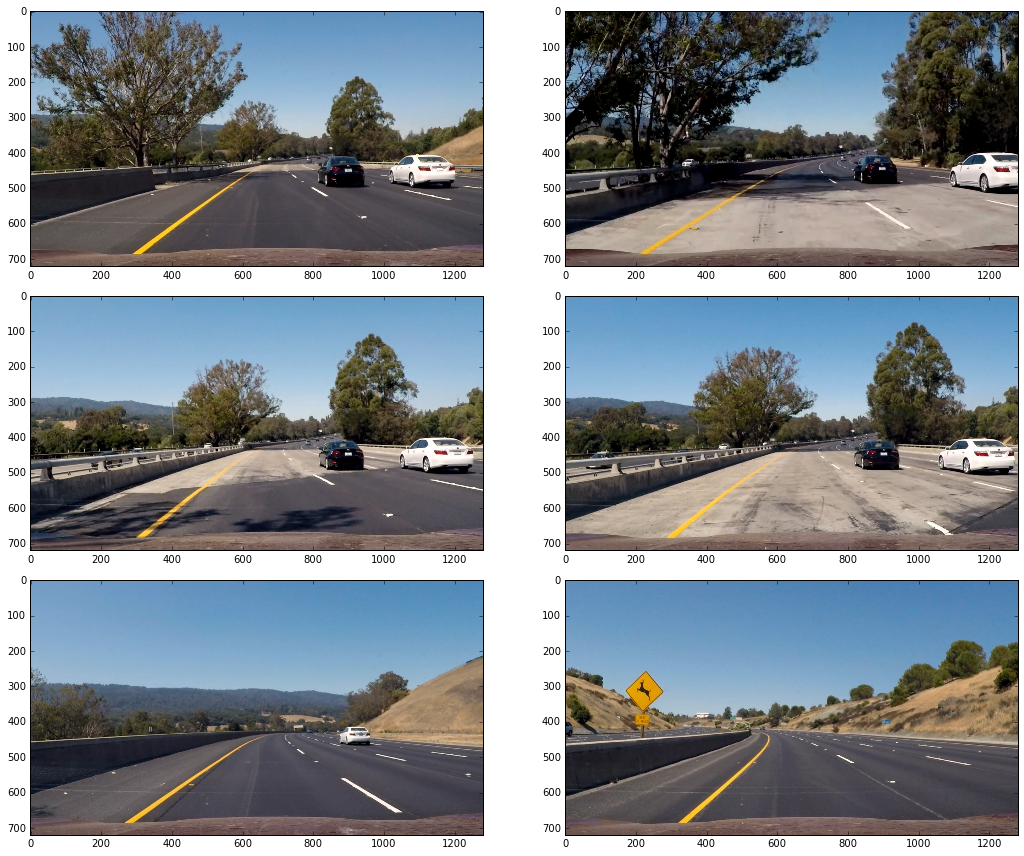

In [62]:
test_images = [mpimg.imread(path) for path in glob.glob('./test_images/*.jpg')]
show_imgs(test_images)

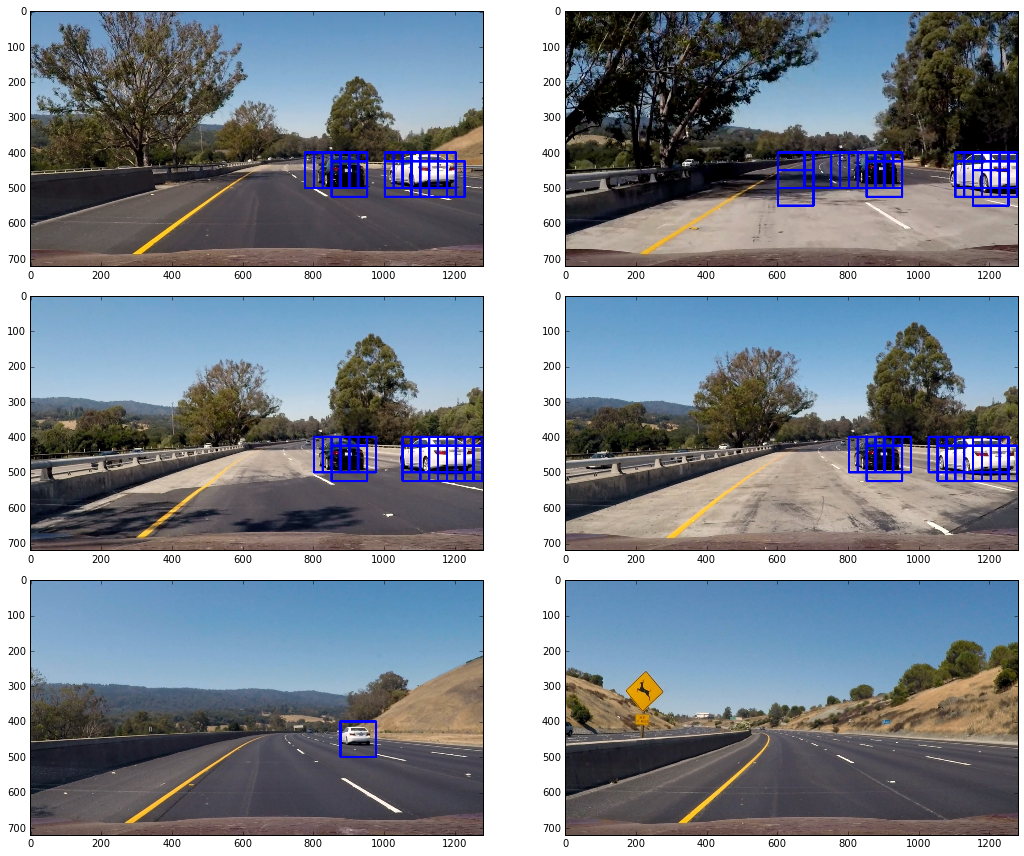

In [100]:
y_start_stop = [400, 550] # Min and max in y to search in slide_window()
draw_winswin_imgs = [draw_wins(image) for image in test_images]
show_imgs(draw_winswin_imgs)

In [64]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,\
              pix_per_cell, cell_per_block, spatial_size, hist_bins, output_img=False):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)
    boxs_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #test_boxs = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, bin_size=spatial_size)
            hist_features = color_hist(subimg, hist_bins)
            
            #print('spatial_feature shape:',spatial_features.shape)
            #print('hist_feature shape:', hist_features.shape)
            #print('hog_feature shape', hog_features.shape)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #debug.boxs_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                boxs_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
              
    if output_img == True:
        return draw_img
    else:
        return boxs_list     

In [65]:
ystart = 400
ystop = 550

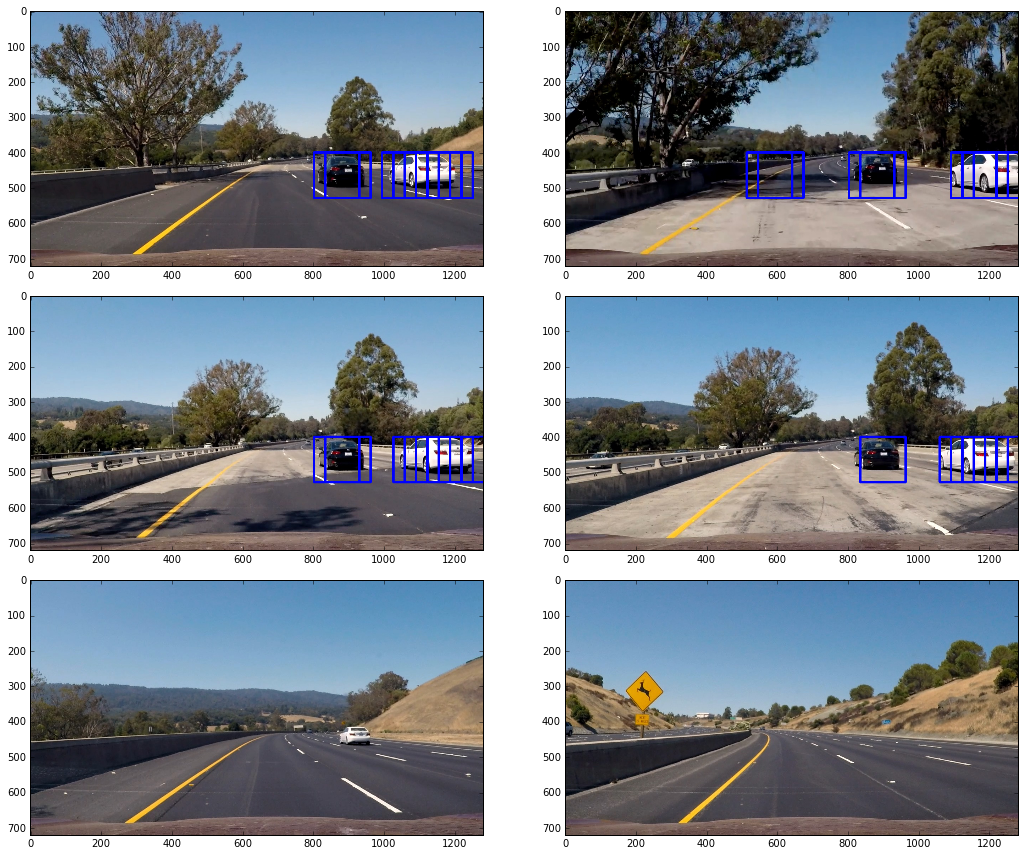

In [66]:
scale_factor = 2
drawboxs_test_images = [find_cars(image, ystart, ystop, scale_factor, svc,
                        X_scaler, orient, pix_per_cell, cell_per_block,
                        spatial_size, hist_bins,True) for image in test_images]
show_imgs(drawboxs_test_images)

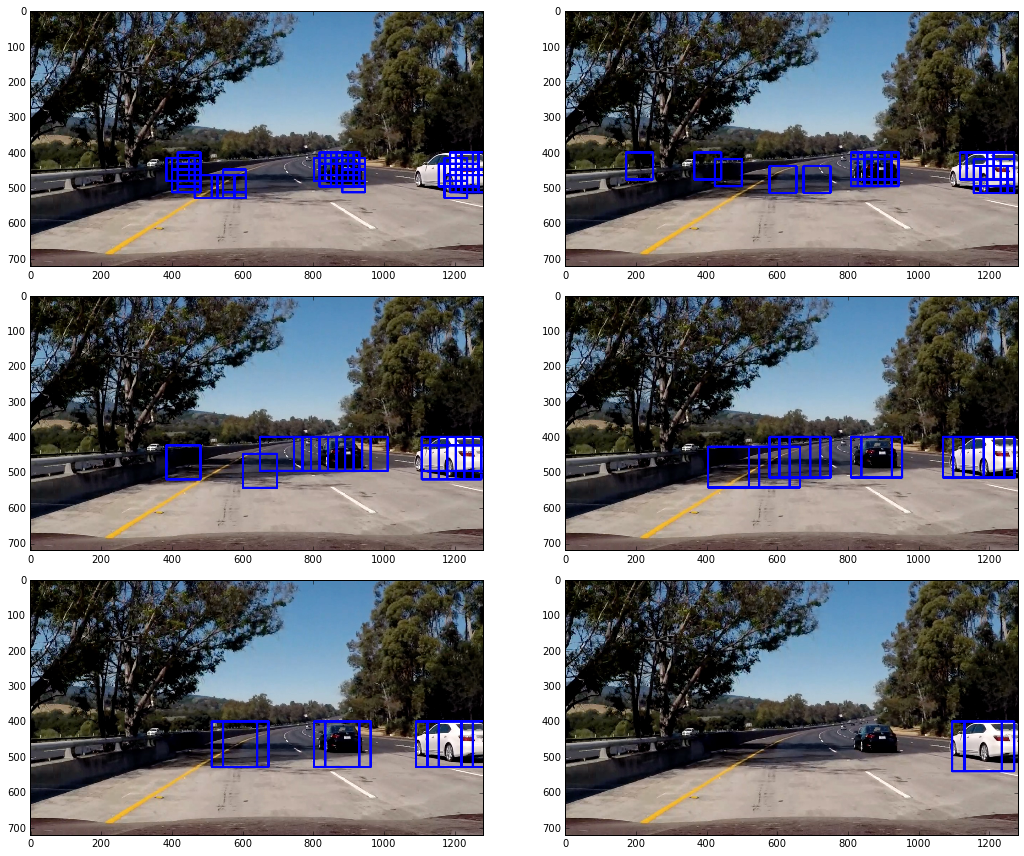

In [94]:
scalers = [1, 1.2, 1.5, 1.8 ,2, 2.2]
test_draw_imgs = [find_cars(test_images[1], ystart, ystop, scale_factor, svc,
                              X_scaler, orient, pix_per_cell, cell_per_block,
                              spatial_size, hist_bins, True) for scale_factor in scalers]
show_imgs(test_draw_imgs, fig_name='scales_car_detect.png')

In [70]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [71]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [72]:
def draw_labeled_bboxes(img, labels):
    image = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return image

In [73]:
def car_bboxes(image, scalers, ystart, ystop):
    bboxes_list = []
    #scalers = [1, 1.4, 1.8 ,2, 2.5, 3.2]
    for scale_factor in scalers:
        bbox_list = find_cars(image, ystart, ystop, scale_factor, svc,
                         X_scaler, orient, pix_per_cell, cell_per_block,
                         spatial_size, hist_bins)
        if len(bbox_list) != 0:
            bboxes_list.append(bbox_list)
        
    return bboxes_list

In [140]:
debug_img = test_images[1]
scalers = [1, 1.4, 1.8 ,2, 2.5, 3.2]
test_bboxes_list = car_bboxes(debug_img, scalers, 400, 550)

In [141]:
test_bboxes_list = np.concatenate(test_bboxes_list)

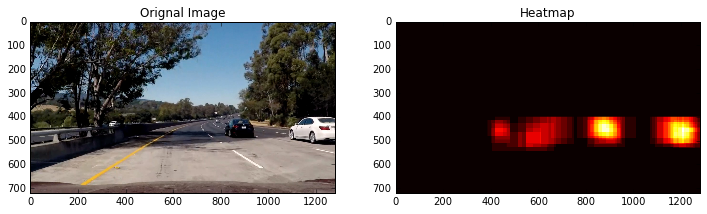

In [150]:
test_heat = np.zeros_like(test_images[1][:,:,0]).astype(np.float)
test_heat = add_heat(test_heat, test_bboxes_list)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(debug_img)
plt.title('Orignal Image')
plt.subplot(122)
plt.imshow(test_heat, cmap='hot')
plt.title('Heatmap')
plt.savefig('./output_images/heatmap.png')

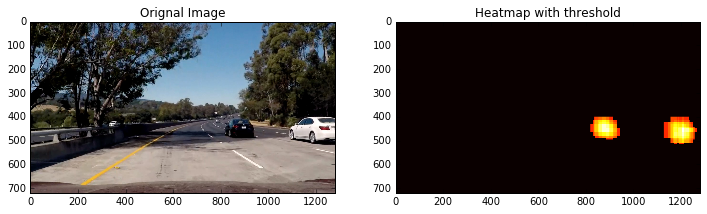

In [152]:
thresh_test_heat = apply_threshold(test_heat, threshold=8)
thresh_test_heat = np.clip(thresh_test_heat, 0, 255)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(debug_img)
plt.title('Orignal Image')
plt.subplot(122)
plt.imshow(test_heat, cmap='hot')
plt.title('Heatmap with threshold')
plt.savefig('./output_images/heatmap_thresh.png')

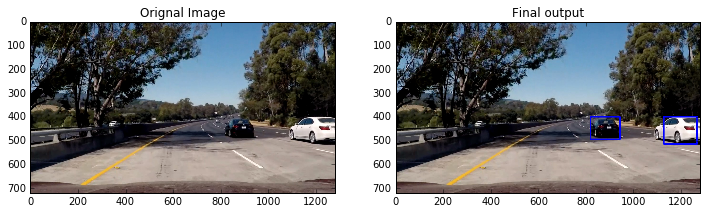

In [161]:
from scipy.ndimage.measurements import label
labels = label(heat_map)
test_label_car_img = draw_labeled_bboxes(debug_img, labels)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(debug_img)
plt.title('Orignal Image')
plt.subplot(122)
plt.imshow(test_label_car_img)
plt.title('Final output')
plt.savefig('./output_images/final_output.png')

In [158]:
def find_car_image(image):
    scalers = [ 1.4, 1.8 ,2, 2.5]
    bboxes_list = car_bboxes(image, scalers, 400, 550)
    
    if len(bboxes_list) == 0:
        output_img = image
    else:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        #print('heat1 dtype', heat.dtype)
        bboxes_list = np.concatenate(bboxes_list)
        heat = add_heat(heat, bboxes_list)
        #print('heat2 dtype', heat.dtype)

        heat = apply_threshold(heat, threshold=6)
        heat_map = np.clip(heat, 0, 255)

        labels = label(heat_map)
        label_car_img = draw_labeled_bboxes(np.copy(image), labels)
        output_img = label_car_img
    
    return output_img

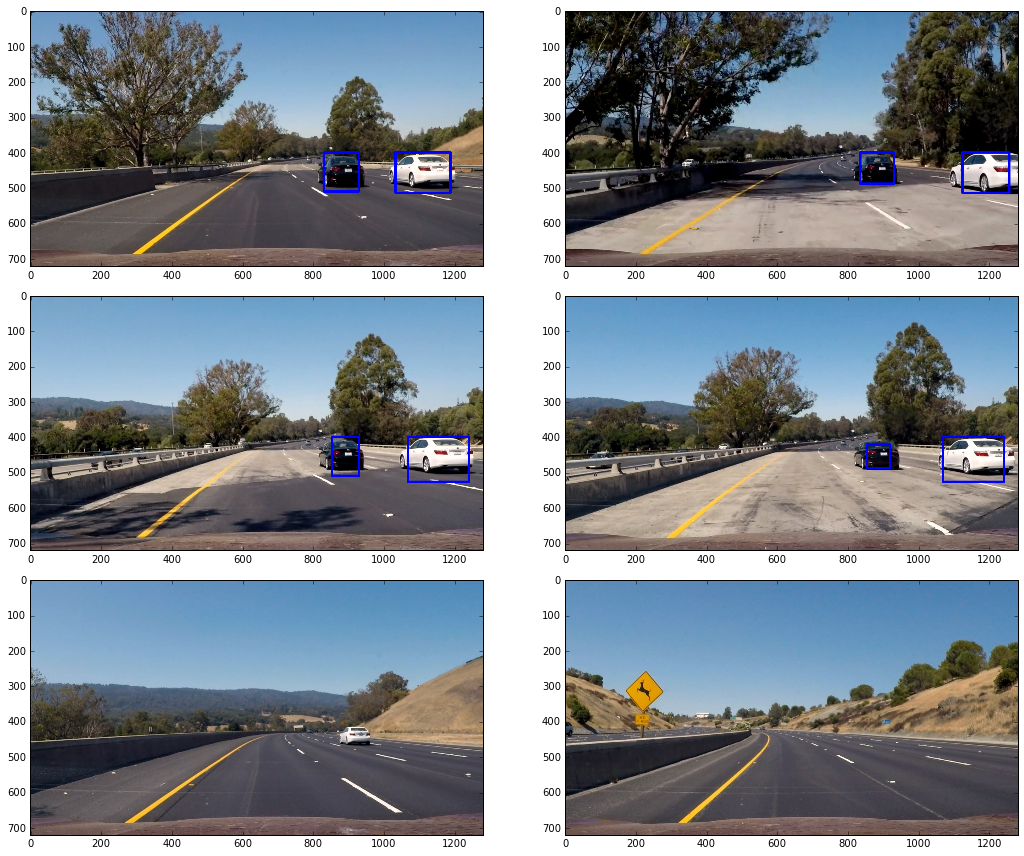

In [162]:
detect_car_imgs = [find_car_image(image) for image in test_images]
show_imgs(detect_car_imgs, fig_name='final_output_imgs.png')

In [164]:
from collections import deque
class Detect_cars():
    def __init__(self, buf):
        #self.buf_weight = buf_weight
        
        self.image = None
        
        self.heatmap_list = deque(maxlen=buf)
        
        #self.best_heatmap = []
        
        self.heat = None
        
        self.debug_heatmap_list = []
        self.debug_best_heatmap_list = []
        
        
        
        
    def add_heat(self, boxes_list, thresh):
        heatmap = np.zeros_like(self.image[:,:,0]).astype(np.float)
        
        # Iterate through list of bboxes
        
        if len(boxes_list) > 0:
            boxes_list = np.concatenate(boxes_list)
            for box in boxes_list:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            heatmap[heatmap <= thresh] = 0
            
        self.heatmap_list.append(heatmap)
        #self.debug_heatmap_list.append(heatmap)
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    
    def draw_labeled_bboxes(self, labels):
        image = np.copy(self.image)
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return image        

In [189]:
def find_car_video(image):
    scalers = [1, 1.2, 1.5, 1.8 ,2]
    #scalers = [ 1.4, 1.8 ,2, 2.5]
    boxes_list = car_bboxes(image, scalers, 400, 550)
    
    detect_car.image = image
    ###############################
    detect_car.add_heat(boxes_list=boxes_list, thresh=8)
        
    if len(detect_car.heatmap_list) == 0:
        heatmap = detect_car.heatmap_list[0]
        heatmap = np.clip(heatmap, 0, 255)
        
        #detect_car.debug_best_heatmap_list.append(heatmap)
        
    else:
        neam_heatmap = np.mean(detect_car.heatmap_list, axis=0)
        
        heatmap = detect_car.apply_threshold(neam_heatmap, threshold=8)
        heatmap = np.clip(heatmap, 0, 255)
        #detect_car.debug_best_heatmap_list.append(heatmap)
    ###############################
    #detect_car.add_heat(boxes_list=boxes_list, thresh=3)
    #heatmap = detect_car.heatmap_list[-1]
    labels = label(heatmap)
    result = detect_car.draw_labeled_bboxes(labels=labels)
    return result

In [195]:
detect_car = Detect_cars(buf=5)

In [196]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [197]:
test_output = './output_test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip('./test_video.mp4')
test_clip = clip.fl_image(find_car_video) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./output_test_video.mp4
[MoviePy] Writing video ./output_test_video.mp4



 97%|█████████▋| 38/39 [00:50<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_test_video.mp4 

CPU times: user 2min 15s, sys: 4.93 s, total: 2min 20s
Wall time: 51.2 s


In [193]:
detect_car = Detect_cars(buf=5)

In [ ]:
test_output = './output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip('./project_video.mp4')
test_clip = clip.fl_image(find_car_video) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)